<a href="https://colab.research.google.com/github/SheikhMudassarHanif/NLP/blob/main/TextTranslationRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**I Will be Implementing text translation using Simple RNN and LSTM and compare their performance**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#
import tensorflow as tf
from tensorflow import keras

In [2]:
excel_file_path = '/content/parallel-corpus.xlsx'
column_names = pd.read_excel(excel_file_path, nrows=0).columns.tolist()
df = pd.read_excel(excel_file_path,usecols=[column_names[0],column_names[1]])
df.dropna(inplace=True)
df.head()

,SENTENCES,MEANING
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...


In [3]:
column_names

['SENTENCES ', 'MEANING']

In [4]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [5]:
len(train),len(val),len(test)

(23693, 2962, 2962)

In [7]:

from LughaatNLP import LughaatNLP
urdu_text_processing = LughaatNLP()

In [8]:
t1=df['MEANING'][0]

In [9]:
t1

'میں اپنے والدین سے کیسے بات کروں ؟'

In [10]:
urdu_text_processing.normalize(t1)

'میں اپنے والدین سے کیسے بات کروں ؟'

In [11]:
def Normalize_label(text):
    # Check if the input is not a string
    if not isinstance(text, str):
        text = str(text)  # Convert it to a string
    return urdu_text_processing.normalize(text)


In [12]:
df['MEANING']=df['MEANING'].apply(Normalize_label)

In [13]:
import re

def Normalize_Input(text):
    # Check if the input is not a string
    if not isinstance(text, str):
        text = str(text)  # Convert non-string values to string
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text


In [14]:
df['SENTENCES ']=df['SENTENCES '].apply(Normalize_Input)

#Input and Labels normalized now converting them into embeddings


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Hyper parameters adjustment

In [16]:
vocab_size=1000
embedding_dim=50
max_length=120
trunc_type='post'
oov_tok='<OOV>'

extracted the dataset into relative segments train test validation

In [17]:
train_inputs=train['SENTENCES '].values
val_inputs=val['SENTENCES '].values
test_inputs=test['SENTENCES '].values


val_inputs_str=[str(x) for x in val_inputs]
test_inputs_str=[str(x) for x in test_inputs]
train_inputs_str = [str(x) for x in train_inputs]


#tokenization of input (english sentences)
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_inputs_str)

#vectorization of input

train_sequences = tokenizer.texts_to_sequences(train_inputs_str)
val_sequences = tokenizer.texts_to_sequences(val_inputs_str)
test_sequences = tokenizer.texts_to_sequences(test_inputs_str)

#Pad the sequences to ensure equal length
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)


In [18]:
train_labels=train['MEANING'].values
train_labels = [str(x) for x in train_labels]
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_labels)

In [19]:
train_labels_sequences = tokenizer.texts_to_sequences(train_labels)
padded_train_labels = pad_sequences(train_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [20]:
val_labels=val['MEANING'].values
val_labels = [str(x) for x in val_labels]
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(val_labels)
val_labels_sequences = tokenizer.texts_to_sequences(val_labels)
padded_val_labels = pad_sequences(val_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [21]:
test_labels=test['MEANING'].values
test_labels = [str(x) for x in test_labels]
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(test_labels)
test_labels_sequences = tokenizer.texts_to_sequences(test_labels)
padded_test_labels = pad_sequences(test_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [22]:
padded_train_labels.shape,padded_val_labels.shape,padded_test_labels.shape

((23693, 120), (2962, 120), (2962, 120))

Now designing a neural network RNN

In [23]:
#important to check
print(train_padded.dtype)
print(padded_train_labels.dtype),print(padded_val_labels.dtype),print(padded_test_labels.dtype)


int32
int32
int32
int32


(None, None, None)

##Simple RNN layer used

In [24]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),  # Simple RNN layer
    tf.keras.layers.SimpleRNN(128, return_sequences=True),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))  # Output layer for each time step
])

##Used Adam as optimimizer and sparse_categorical_crossentropy for loss calculation because it is used for multiclass classification

In [25]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Assuming train_labels contains your target decoder output data
history = model.fit(train_padded, np.expand_dims(padded_train_labels, -1), epochs=10, validation_data=(val_padded,padded_val_labels))

Epoch 1/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 347s 453ms/step - accuracy: 0.8647 - loss: 1.2918 - val_accuracy: 0.8949 - val_loss: 0.7395
Epoch 2/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 382s 453ms/step - accuracy: 0.8911 - loss: 0.7424 - val_accuracy: 0.8949 - val_loss: 0.7536
Epoch 3/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 389s 462ms/step - accuracy: 0.8934 - loss: 0.7131 - val_accuracy: 0.8949 - val_loss: 0.7602
Epoch 4/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 367s 443ms/step - accuracy: 0.8943 - loss: 0.7051 - val_accuracy: 0.8951 - val_loss: 0.7656
Epoch 5/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 384s 446ms/step - accuracy: 0.8940 - loss: 0.7040 - val_accuracy: 0.8951 - val_loss: 0.7694
Epoch 6/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 386s 451ms/step - accuracy: 0.8946 - loss: 0.6974 - val_accuracy: 0.8952 - val_loss: 0.7719
Epoch 7/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 374s 440ms/step - accuracy: 0.8934 - loss: 0.7023 - val_accuracy: 0.8951 - val_loss: 0.7735
Epoch 8/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 388s 447ms/step - accuracy: 0.8952 -

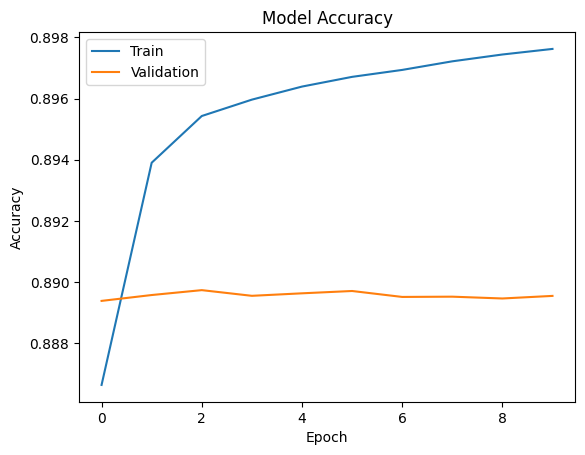

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

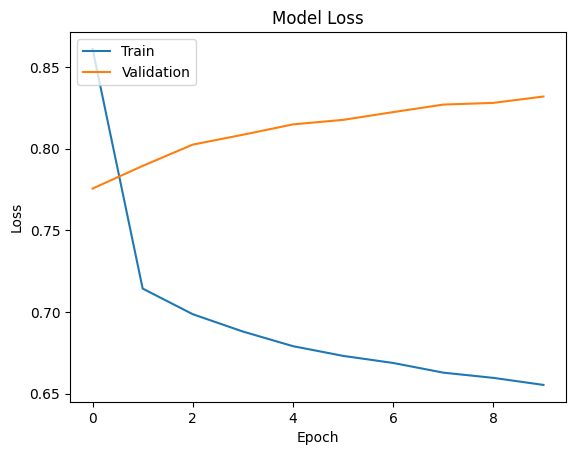

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [ ]:

def Model_ready_input(text):
  text=str(text)
  text=Normalize_Input(text)
  text_sequence = tokenizer.texts_to_sequences([text])
  text_padded = pad_sequences(text_sequence, maxlen=max_length, truncating=trunc_type)
  return text_padded


##Simple RNN  Result on test dataset  

---
accuracy: 0.8931 - loss: 0.8018


In [ ]:
model.evaluate(test_padded,padded_test_labels)


93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.8931 - loss: 0.8018


[0.80629962682724, 0.8925192952156067]

#Translating english to urdu

In [ ]:
text='How are You?'
text=Model_ready_input(text)
predictions=model.predict(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:

def Model_ready_input(text):
    text = str(text)  # Ensure the text is a string
    text = Normalize_Input(text)  # Normalize the input text
    text_sequence = tokenizer.texts_to_sequences([text])  # Tokenize the input
    text_padded = pad_sequences(text_sequence, maxlen=max_length, truncating=trunc_type)  # Pad the sequence
    return text_padded

# Prepare your input text
text = 'How are You?'
text_padded = Model_ready_input(text)  # Prepare the input

# Make a prediction
predictions = model.predict(text_padded)

# Print raw prediction output
print("Raw prediction output:", predictions)

# Get the predicted index (assuming your output is structured as (None, max_length, vocab_size))
predicted_index = np.argmax(predictions, axis=-1)

# Reverse the word index to map indices to words
reverse_word_index = {value: key for key, value in tokenizer.word_index.items()}

# Decode the predicted index to Urdu words
translated_text = ' '.join([reverse_word_index.get(idx, '<OOV>') for idx in predicted_index[0] if idx != 0])
print(f"Predicted Urdu Translation: {translated_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Raw prediction output: [[[9.8031497e-01 1.1486697e-03 7.7980134e-04 ... 4.8863262e-06
   3.0653121e-06 4.2209022e-06]
  [9.6998000e-01 4.4409130e-03 1.7128773e-03 ... 3.5397650e-06
   3.0141323e-06 4.9776218e-06]
  [9.6955991e-01 4.7952062e-03 1.6975921e-03 ... 3.2243481e-06
   2.9426699e-06 4.5458628e-06]
  ...
  [7.9371281e-02 3.5564598e-01 3.3910878e-02 ... 1.8770156e-04
   2.6377491e-04 4.9051810e-05]
  [2.1996988e-02 4.3687117e-01 2.6421394e-02 ... 4.2164247e-04
   3.1261533e-04 4.4887547e-05]
  [8.5372180e-03 4.3623987e-01 1.9400986e-02 ... 3.2446042e-04
   1.9762252e-04 7.8391102e-05]]]
Predicted Urdu Translation: <OOV> <OOV> <OOV>
